In [1]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

/home/suv/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:38211 Dashboard: http://127.0.0.1:39891/status,Cluster Workers: 4 Cores: 4 Memory: 16.69 GB


In [2]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
X

,Array,Chunk
Bytes,16.00 MB,160.00 kB
Shape,"(100000, 20)","(1000, 20)"
Count,100 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [3]:
%%time
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

CPU times: user 245 ms, sys: 11.5 ms, total: 257 ms
Wall time: 455 ms


In [4]:
import dask
import xgboost
import dask_xgboost

In [10]:
%%time
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

CPU times: user 1.67 s, sys: 71.4 ms, total: 1.74 s
Wall time: 5.51 s


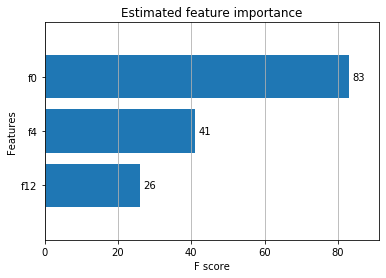

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [7]:
%%time 
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_hat

CPU times: user 32.9 ms, sys: 0 ns, total: 32.9 ms
Wall time: 43.4 ms


,Array,Chunk
Bytes,60.00 kB,600 B
Shape,"(15000,)","(150,)"
Count,100 Tasks,100 Chunks
Type,float32,numpy.ndarray


In [8]:
%%time
from sklearn.metrics import roc_curve

y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

CPU times: user 1.16 s, sys: 68.1 ms, total: 1.23 s
Wall time: 1.91 s


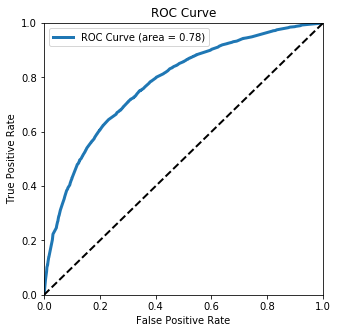

CPU times: user 136 ms, sys: 4.69 ms, total: 141 ms
Wall time: 166 ms


In [9]:
%%time
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()